In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180.
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In the previous tutorial (:ref:`astrometric`) we showed how to fit an orbit with `exoplanet` where only astrometric information is available. In this notebook we'll extend that same example to also include the available radial velocity information on the system. 

## Data 
As before we'll use the astrometric and radial velocity measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract), and the radial velocities  are from [Tokovinin 1993](https://ui.adsabs.harvard.edu/#abs/1993AstL...19...73T/abstract). 

In [4]:
# grab the formatted data and do some munging

dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"
# dirname = "/home/ian/Research/Stars/TWA3/TWA-3-orbit/test-files/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

rv1_data = ascii.read(dirname + "rv1.txt", format="csv")
rv2_data = ascii.read(dirname + "rv2.txt", format="csv")

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

# adjust the errors as before
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

In [6]:
# take out the data as only numpy arrays
rv1 = rv1_data["rv"].data
rv1_err = rv1_data["err"].data

rv2 = rv2_data["rv"].data
rv2_err = rv2_data["err"].data

# adapt the dates of the RV series 
rv1_dates = Time(rv1_data["date"] + 2400000, format="jd")
rv1_jds = rv1_dates.value
rv2_dates = Time(rv2_data["date"] + 2400000, format="jd")
rv2_jds = rv2_dates.value

rv1_yr = rv1_dates.decimalyear
rv2_yr = rv2_dates.decimalyear

As before, we'll plot $\rho$ vs. time and P.A. vs. time. We'll also add the RV time series for the primary and secondary stars.

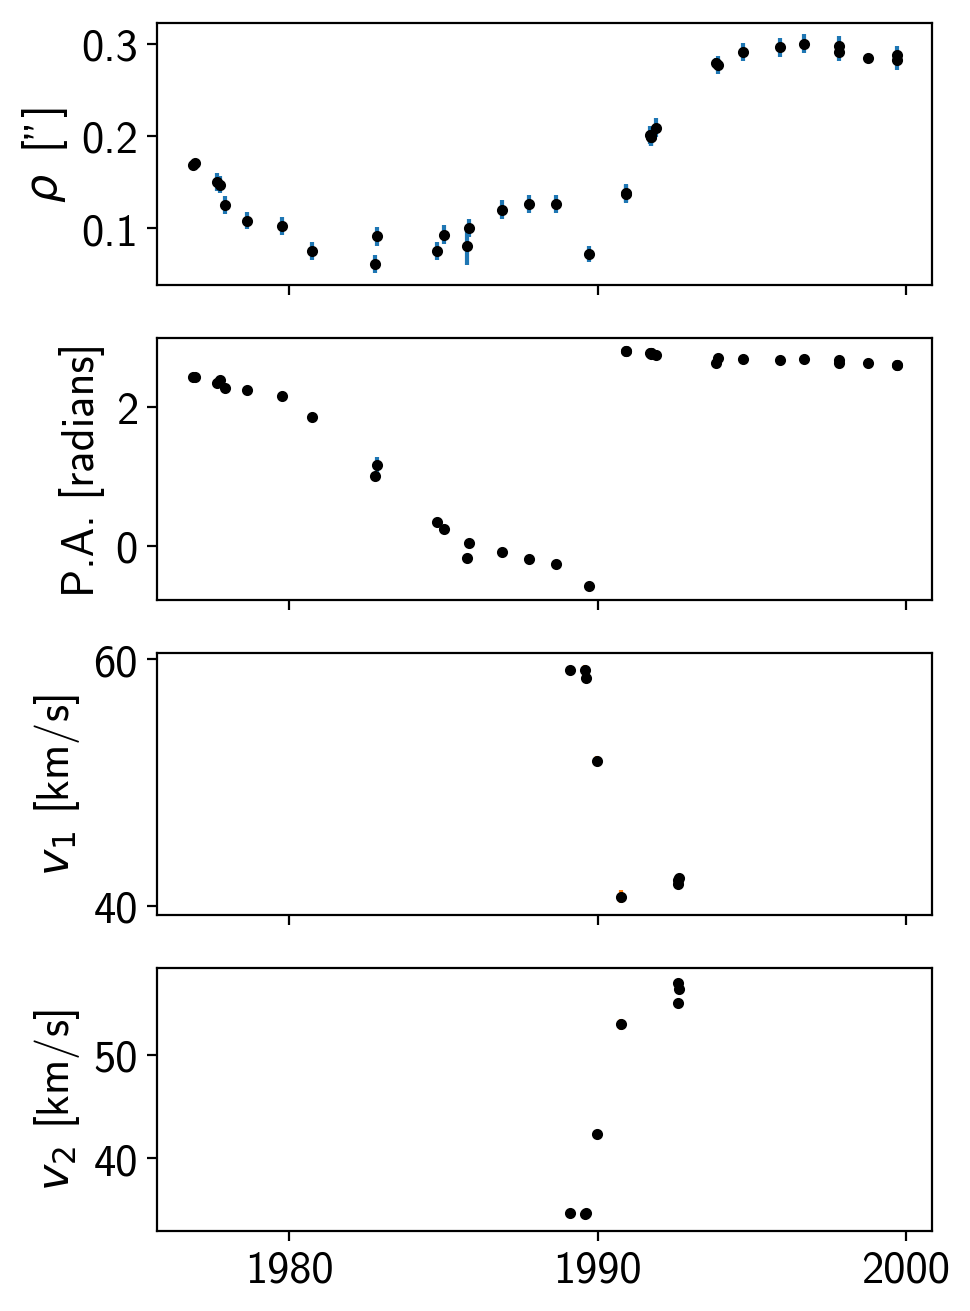

In [7]:
pkw = {"ls":"", "color":"k", "marker":"."}
ekw = {"ls":"", "color":"C1"}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(astro_yrs, rho_data, **pkw)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, **pkw)
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(rv1_yr, rv1, **pkw)
ax[2].errorbar(rv1_yr, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(rv2_yr, rv2, **pkw)
ax[3].errorbar(rv2_yr, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

In [8]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

In [10]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [15]:
# testing unique inputs 

# conversion constant
au_to_R_sun = (constants.au / constants.R_sun).value

a_ang = 0.324 # arcsec
parallax = 24.05 # milliarcsec 
dpc = 1e3 / parallax
a = a_ang * dpc # au

e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

gamma = 47.97 # km/s; systemic velocity

# kappa = a1 / (a1 + a2)
kappa = 0.45 

# calculate Mtot from a, P
Mtot = calc_Mtot(a, P)

M2 = kappa * Mtot
M1 = Mtot - M2

# calculate M1, M2 from kappa and Mtot 
print("Masses from Kepler's third law M1:{:.2f}, M2:{:.2f}, Mtot:{:.2f}".format(M1, M2, Mtot))

# n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, 
                               incl=i, ecc=e, omega=omega, Omega=Omega, m_planet=M2)


print("m_planet: {:.2f}".format(orbit.m_planet.eval()))
print("m_star: {:.2f}".format(orbit.m_star.eval()))
print("m_tot: {:.2f}".format(orbit.m_total.eval()))

Masses from Kepler's third law M1:1.62, M2:1.33, Mtot:2.95
m_planet: 1.33
m_star: 0.27
m_tot: 1.60


In [12]:
# Orbital elements from Pourbaix et al. 1998

# conversion constant
au_to_R_sun = (constants.au / constants.R_sun).value

a_ang = 0.324 # arcsec
parallax = 24.05 # milliarcsec 
# parallax = 27.05 # milliarcsec 
dpc = 1e3 / parallax
a = a_ang * dpc # au

print(a)

e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]


gamma = 47.97 # km/s; systemic velocity


# kappa = a1 / (a1 + a2)
kappa = 0.45 

# calculate Mtot from a, P
Mtot = calc_Mtot(a, P)

M2 = kappa * Mtot
M1 = Mtot - M2

print(M1, M2, Mtot)
# calculate M1, M2 from kappa and Mtot 

# n = 2 * np.pi / P
# t0 = (phi + w) / n

# n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, 
                               incl=i, ecc=e, omega=omega, Omega=Omega, m_planet=M2, m_star=M1)

# make a theano function to get stuff from orbit 
times = tt.vector("times")
ang = orbit.get_relative_angles(times) # the rho, theta measurements


output_units = u.km / u.s
conv = (1 * u.R_sun / u.day).to(output_units).value

    
rv1_model = conv * orbit.get_star_velocity(times)[2] + gamma
rv2_model = conv * orbit.get_planet_velocity(times)[2] + gamma

f_ang = theano.function([times], ang)
f_rv1 = theano.function([times], rv1_model)
f_rv2 = theano.function([times], rv2_model)



t = np.linspace(T0 - P, T0 + P, num=100) # days

rho_phys, theta_model = f_ang(t)
# convert back from R_sun to arcseconds
rho_model = (rho_phys / au_to_R_sun) / dpc # arcsec

rv1s = f_rv1(t)
rv2s = f_rv2(t)

13.471933471933472
1.6213766232228985 1.326580873546008 2.9479574967689066


ValueError: if both a and period are given, you can't also define rho_star or m_star

In [84]:
print(orbit.m_star.eval())

0.2745552112140823


Text(0, 0.5, '$v_2$ [km/s]')

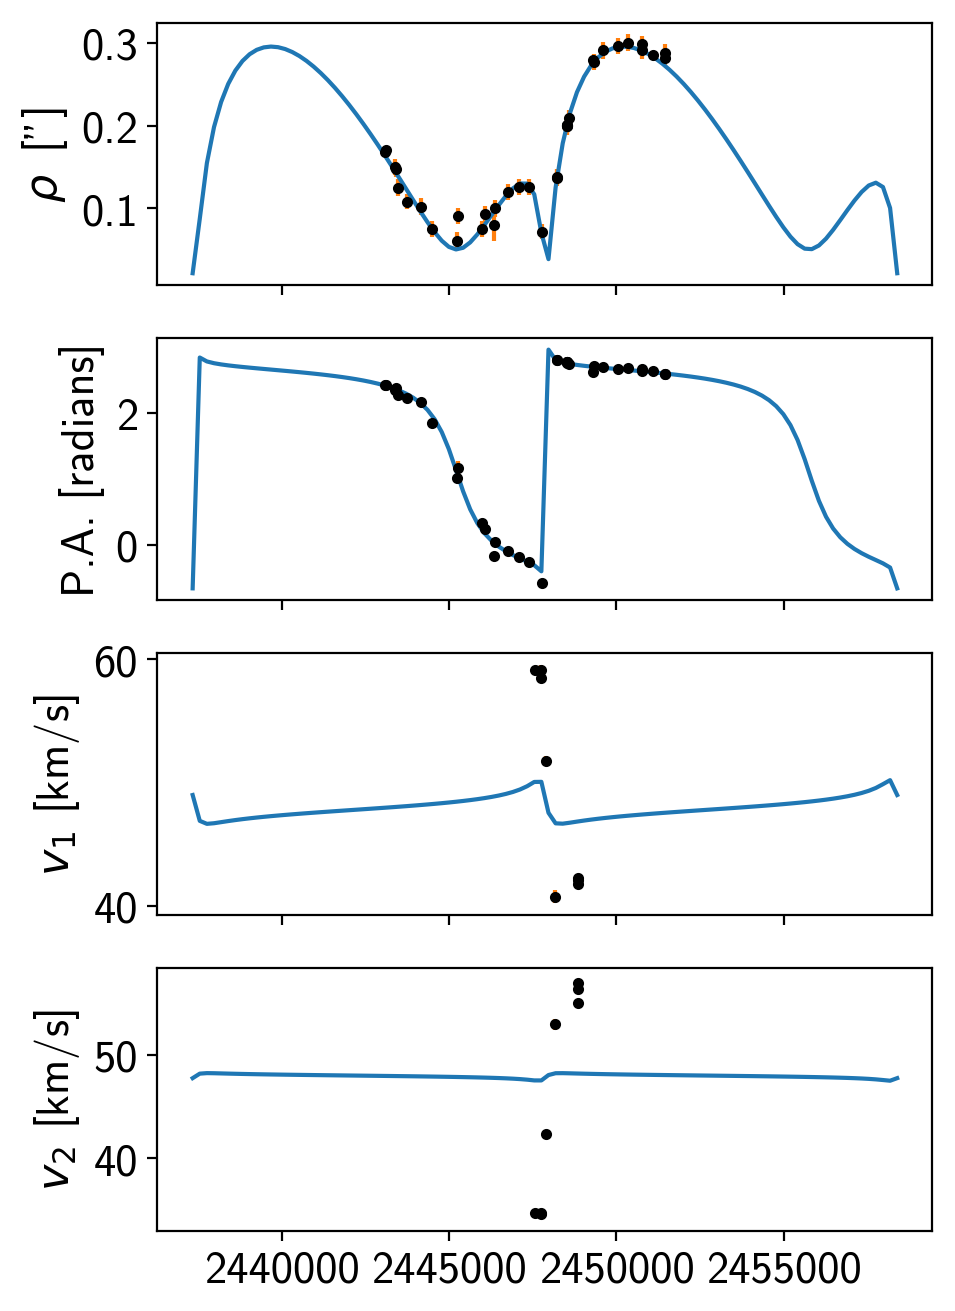

In [81]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(t, rho_model)
ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta_model)
ax[1].plot(astro_jds, theta_data, **pkw)
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(t, rv1s)
ax[2].plot(rv1_jds, rv1, **pkw)
ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(t, rv2s)
ax[3].plot(rv2_jds, rv2, **pkw)
ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]")

In [ ]:
fig, ax = plt.subplots(nrows=4, sharex=True, format=(5,8))
ax[0].plot(t, rho)
ax[0].plot(astro_yrs, rho_data, ".")
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta * 180/np.pi)
ax[1].plot(astro_yrs, theta_data, ".")
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [degrees]');

ax[2].plot(t, rv1s)


ax[3].plot(t, rv2s)

In [ ]:
plt.plot(Y, X, "o")
plt.gca().invert_xaxis()
plt.xlabel(r"$\Delta \alpha \cos \delta$ [arcsec]")
plt.ylabel(r"$\Delta \delta$ [arcsec]");

Orbit fitting tip from Mike Fitzgerald to use $\Omega+\omega$ and $\Omega-\omega$ for fitting, since you can get unambiguous constraints on those parameters. 

Without radial velocity information, there is a $180^\circ$ degeneracy in the position angle of the ascending node, $\Omega_2$.

In [ ]:
# Sample the orbit 

# with pm.Model() as model:
    
#     t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs))
#     P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)
#     omega = xo.distributions.Angle("omega", shape=2, testval=np.zeros(2))


orbit = astro.AstrometricOrbit(a_ang=a, t0=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega)
